In [ ]:
%pip install pandas

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib

In [ ]:
%pip install seaborn

In [ ]:
import re
import math

import pandas as pd
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as mplPlt
import matplotlib.colors as mplColors
import matplotlib.animation as mplAnimation
import matplotlib.dates as mdates

import seaborn as sns

In [ ]:
# Read the input CSV file with auto-detected delimiter and specified encoding
qpu_file = 'Datasets/QPU list 2025.csv'
qpu_df = pd.read_csv(qpu_file, sep=None, engine='python', encoding='latin1')

# Remove parenthetical acronyms from 'Manufacturer' column
qpu_df['Manufacturer'] = qpu_df['Manufacturer'].str.replace(r'\s*\([^)]*\)', '', regex=True)

# Split the Manufacturers from a single string to an array
for index, row in qpu_df.iterrows():
    qpu_df.at[index, 'Manufacturer'] = row['Manufacturer'].split(" + ")

In [ ]:
# Load the organizations CSV with semicolon delimiter
org_file = 'Datasets/quantum_computing_report___organizations.csv'
org_df = pd.read_csv(org_file, sep=';', encoding='latin1')

# Split the Organizations from a single string to an array
for index, row in org_df.iterrows():
     org_df.at[index, 'Location'] = row['Location'].split(", ")

In [ ]:
#List of all unique Manufacturers
UniqueManufacturers = qpu_df["Manufacturer"].explode().dropna().unique().tolist()

#List of all unique Organizations
UniqueOrganizations = org_df['Organization'].dropna().unique().tolist()

In [ ]:
# -----------------------------------------------------------
# 1. Helper functions
# -----------------------------------------------------------
def tokenize(text: str) -> list[str]:
    text = text.lower()
    split_re = re.compile(r"[^A-Za-z0-9]+")
    pieces = split_re.split(text)
    tokens = [] 
    for p in pieces:
        if p:
            tokens.append(p)
    return tokens


def tfidf_vector(tokens: list[str], idf: dict[str, float]) -> dict[str, float]:
    tf = defaultdict(int)
    for tok in tokens:
        tf[tok] += 1
    for tok in tf:
        tf[tok] *= idf[tok]
    return tf


def cosine_sim(a: dict[str, float], b: dict[str, float]) -> float:
    num = 0.0
    for key, aval in a.items():
        num += aval * b.get(key, 0.0)

    sum_sq_a = 0.0
    for val in a.values():
        sum_sq_a += val * val
    len_a = math.sqrt(sum_sq_a)

    sum_sq_b = 0.0
    for val in b.values():
        sum_sq_b += val * val
    len_b = math.sqrt(sum_sq_b)

    denom = len_a * len_b

    if denom == 0.0:
        return 0.0
    else:
        return num / denom




# -----------------------------------------------------------
# 2. Build IDF dictionary
# -----------------------------------------------------------
tokens_all = []
for t in UniqueManufacturers + UniqueOrganizations:
    tokens_all.append(tokenize(t)) 

df_counts = defaultdict(int)
for doc in set(tuple(t) for t in tokens_all):
    for tok in set(doc):
        df_counts[tok] += 1

idf = defaultdict(int)
for key in df_counts:
    idf[key] = math.log((len(UniqueManufacturers) + len(UniqueOrganizations)  + 1)/(df_counts[key] + 1)) + 1



# -----------------------------------------------------------
# 3. Pre-compute vectors
# -----------------------------------------------------------
manu_vecs = {}
for m in UniqueManufacturers:
    manu_vecs[m] = tfidf_vector(tokenize(m), idf)

org_vecs = {}
for o in UniqueOrganizations:
    org_vecs[o] = tfidf_vector(tokenize(o), idf)





# -----------------------------------------------------------
# 4. Find best-matching organisation for every manufacturer   |
# -----------------------------------------------------------
best_match = {}

for m, v_m in manu_vecs.items():
    best_o = None
    best_s = -1.0
    for o, v_o in org_vecs.items():
        s = cosine_sim(v_m, v_o)
        if s > best_s:
            best_o, best_s = o, s
    best_match[m] = (best_o, best_s)

In [ ]:
# -----------------------------------------------------------
# 1.  Build the three TF-IDF columns in one pass
# -----------------------------------------------------------
matched_orgs = []
matched_scores = []
matched_locs = []


for _, qpu_row in qpu_df.iterrows():
    manufacturers = qpu_row["Manufacturer"]

    row_orgs = []
    row_scores = []
    row_locs = []

    for mfr in manufacturers:
        org, score = best_match.get(mfr, (None, None))
        row_orgs.append(org)
        row_scores.append(score)

        # on-the-fly organisation -> location lookup
        loc_val = None
        for _, org_row in org_df.iterrows():
            if org_row["Organization"] == org:
                row_locs = org_row["Location"]
                break

    matched_orgs.append(row_orgs)
    matched_scores.append(row_scores)
    matched_locs.append(row_locs)



# -----------------------------------------------------------
# 2.  Attach the new columns
# -----------------------------------------------------------
qpu_df["TFIDF_Matched_Organization"] = matched_orgs
qpu_df["TFIDF_Match_Score"]          = matched_scores
qpu_df["TFIDF_Matched_Location"]     = matched_locs


In [ ]:
#qpu_df.to_csv('test_join.csv', index=False, sep=';')

In [ ]:
country_counter = Counter()

for index, row in qpu_df.iterrows():
    for c in row['TFIDF_Matched_Location']:
        country_counter[c] += 1

country_counter = Counter(dict(country_counter.most_common()))

In [150]:
def world_hist(counter):
    # --- data --------------------------------------------------------------
    countries = list(counter.keys())
    counts = np.array(list(counter.values()))
    n_bars = len(counts)

    # --- colours -----------------------------------------------------------
    cmap = mplColors.LinearSegmentedColormap.from_list("", ["#A467B5", "#ffffff"], N=16384)
    colors = cmap(np.log1p(25 * np.linspace(0, 1, n_bars)) / np.log1p(25))

    # --- static figure -----------------------------------------------------
    fig, ax = mplPlt.subplots(figsize=(10, 9))
    x = np.arange(n_bars)
    
    bars = ax.bar(x, np.zeros_like(counts), color=colors, edgecolor="black")

    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=90)
    ax.set_ylim(0, counts.max() * 1.1)
    ax.set_title("Numero di modelli di QPU per Nazione", fontsize=16, pad=20)
    ax.set_xlabel("Nazione", fontsize=14, labelpad=30)
    ax.set_ylabel("Numero di modelli di QPU sviluppate", fontsize=14, labelpad=25)

    # --- animation ---------------------------------------------------------
    steps_per_bar = 1
    total_frames = int((n_bars * steps_per_bar) * 1.1)

    def init():
        for bar in bars:
            bar.set_height(0)
        return bars

    def animate(frame):
        bar_idx = frame // steps_per_bar
        prog = (frame % steps_per_bar) / steps_per_bar

        for i, bar in enumerate(bars):
            if i < bar_idx:
                bar.set_height(counts[i])
            elif i == bar_idx:
                bar.set_height(counts[i] * prog)
            else:
                bar.set_height(0)
        return bars

    return mplAnimation.FuncAnimation(fig, animate, init_func=init, frames=total_frames, blit=True)

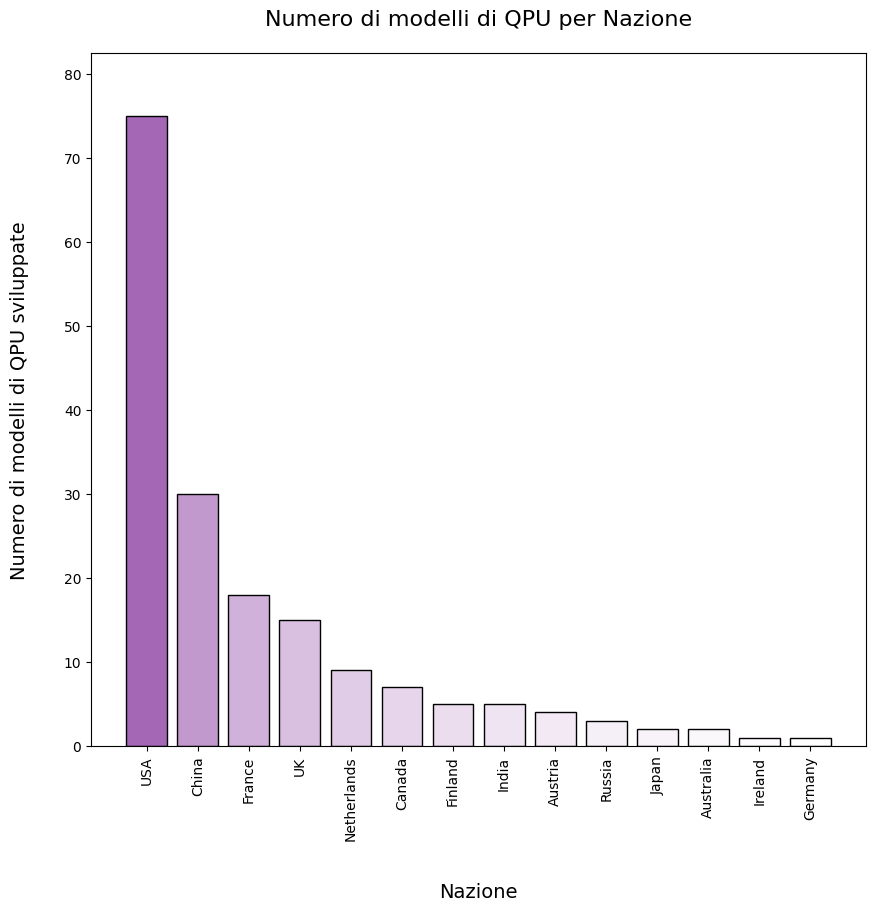

In [151]:
hist_anim = world_hist(country_counter)
hist_anim.save("Media/qpus_histogram.mp4", writer=mplAnimation.FFMpegWriter(fps=20, codec="libx264"), dpi=200)

In [ ]:
qpu_df['Technology'] = qpu_df['Technology'].str.replace(r'\s*\([^)]*\)', '', regex=True)

In [ ]:
qpu_heatmap = pd.DataFrame(columns=['country', 'tech', 'count'])

for index, row in qpu_df.iterrows():
    tech = row['Technology']
    for country in row['TFIDF_Matched_Location']:
        mask = (qpu_heatmap['country'] == country) & (qpu_heatmap['tech'] == tech)
        if mask.any():
            qpu_heatmap.loc[mask, 'count'] += 1
        else:
            qpu_heatmap.loc[len(qpu_heatmap)] = [country, tech, 1]

In [187]:
def qpu_heatmap_fig(df):
    # ------------------------------------------------------------------
    # 1. Convert to matrix form (country x tech)
    # ------------------------------------------------------------------
    heatmap_data = df.pivot_table(index="country", columns="tech", values="count", aggfunc="sum")
    heatmap_data.fillna(0, inplace=True)
    
    
    # ------------------------------------------------------------------
    # 2. Build the logarithmic colour-map
    # ------------------------------------------------------------------
    N = len(qpu_df['Technology'].unique())
    base_cmap = mplColors.LinearSegmentedColormap.from_list("", ["#ffffff", "#A467B5"], N=16384)
    colors = base_cmap(np.log1p(25 * np.linspace(0, 1, N)) / np.log1p(25) + 0.05)
    log_cmap = mplColors.ListedColormap(colors)
    norm = mplColors.LogNorm(vmin=1, vmax=np.nanmax(heatmap_data.values))
    
    
    
    # ------------------------------------------------------------------
    # 3. Create grapgh
    # ------------------------------------------------------------------
    fig, ax = mplPlt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        data=heatmap_data.fillna(0).astype(int),
        ax=ax,
        cmap=log_cmap,
        norm=norm,
        annot=True,
        fmt="d",
        linewidths=.5,
        linecolor="#f0f0f0",
        cbar_kws={
            "label": "count (log scale)",
            "pad": 0.2
        }
    )

    ax.set_title('Nazione x Tecnologia', fontsize=20, pad=20)
    ax.set_xlabel("Technology", fontsize=16, labelpad=30)
    ax.set_ylabel("Country", fontsize=16, labelpad=30)

    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel("count (log scale)", labelpad=15, fontsize=12)

    # Adds border
    for side in ["left", "bottom", "top", "right"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(.25)
        ax.spines[side].set_color("black")

    return fig

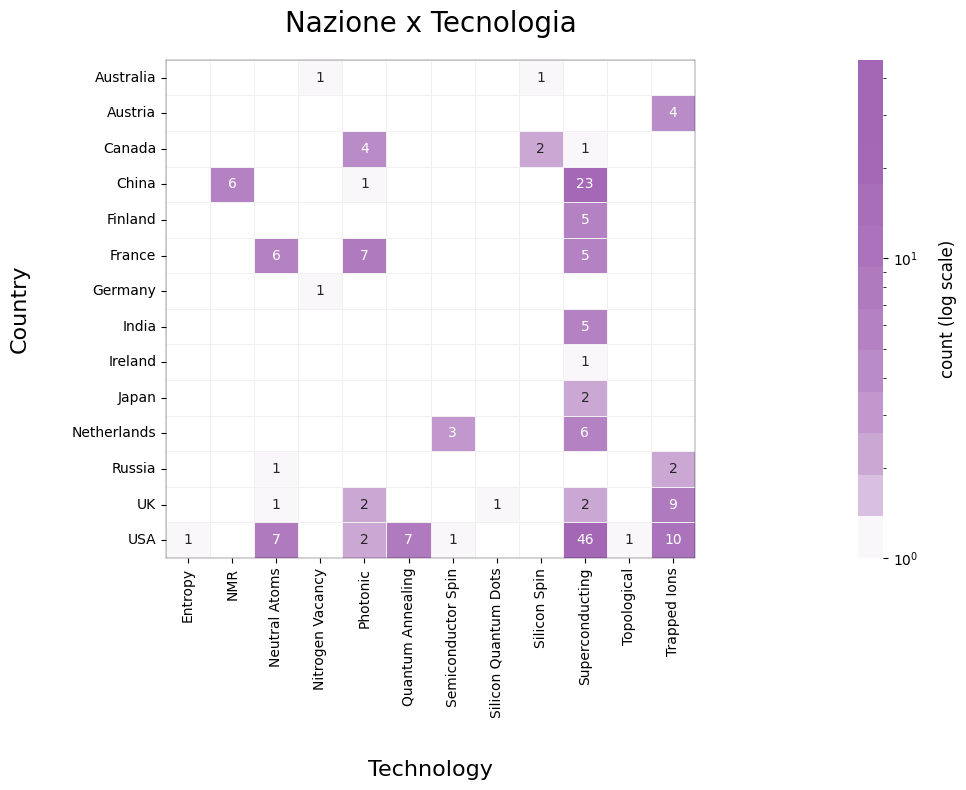

In [188]:
heat_fig = qpu_heatmap_fig(qpu_heatmap)
heat_fig.tight_layout()
heat_fig.savefig("Media/qpus_heatmap.png", dpi=600, bbox_inches="tight")

In [ ]:
# Keep only rows where the model is marked as "Available"
available_df = qpu_df[qpu_df['Availability'].str.strip().str.lower() == 'available']



# Ensure the "Availability Date" is numeric and drop missing values
available_df = available_df.dropna(subset=['Availability Date'])
available_df['Availability Date'] = available_df['Availability Date'].astype(int)



# Group by year of availability and count the number of models
available_models_by_year = available_df.groupby('Availability Date').size().reset_index(name='Model_Count').sort_values('Availability Date').reset_index(drop=True)

In [ ]:
# Compute cumulative sum over the years
cumulative_available_models = pd.DataFrame(columns=['year','available_models'])

running_total = 0
for _, row in available_models_by_year.iterrows():
    running_total += row['Model_Count']
    cumulative_available_models.loc[len(cumulative_available_models)] = [row['Availability Date'], running_total]

In [180]:
def available_qpus():
    # Plot the cumulative line graph
    fig, ax = mplPlt.subplots()
    ax.plot(cumulative_available_models['year'], cumulative_available_models['available_models'], marker='o', color="#A467B5")
    ax.set_xlabel('Anno', fontsize=11, labelpad=30)
    ax.set_ylabel('Modelli di QPU', fontsize=11, labelpad=30)
    ax.set_title('Numero di modelli di QPU disponibili, anno per anno', fontsize=13, pad=20)
    ax.grid(True, color="#f0f0f0")
    return fig

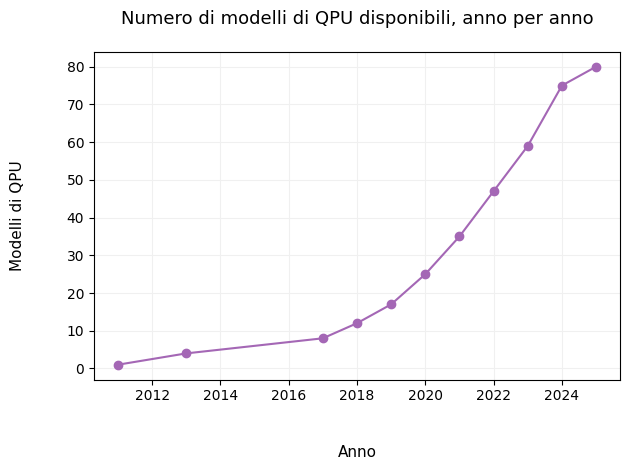

In [181]:
avail_fig = available_qpus()
avail_fig.tight_layout()
avail_fig.savefig("Media/qpus_available.png", dpi=600)

In [182]:
# Keep only rows where the model is marked as "Available"
planned_df = qpu_df[qpu_df['Availability'].str.strip().str.lower() == 'planned']



# Ensure the "Availability Date" is numeric and drop missing values
planned_df = planned_df.dropna(subset=['Availability Date'])
planned_df['Availability Date'] = planned_df['Availability Date'].astype(int)



# Group by year of availability and count the number of models
planned_models_by_year = planned_df.groupby('Availability Date').size().reset_index(name='Model_Count').sort_values('Availability Date').reset_index(drop=True)

In [183]:
cumulative_planned_models = pd.DataFrame(columns=['year','available_models'])
running_total = cumulative_available_models.loc[len(cumulative_available_models) - 1]['available_models']
last_available_year = cumulative_available_models.loc[len(cumulative_available_models) - 1]['year']

for _, row in planned_models_by_year.iterrows():
    if row['Availability Date'] >= last_available_year:
        running_total += row['Model_Count']
        cumulative_planned_models.loc[len(cumulative_planned_models)] = [row['Availability Date'], running_total]

In [184]:
def avail_plan_qpus():
    # Plot the cumulative line graph
    fig, ax = mplPlt.subplots()
    ax.plot(cumulative_available_models['year'], cumulative_available_models['available_models'], marker='o', color="#A467B5")
    ax.plot(cumulative_planned_models['year'], cumulative_planned_models['available_models'], marker='x', color="#CBA7D4")
    ax.set_xlabel('Anno', fontsize=11, labelpad=30)
    ax.set_ylabel('Modelli di QPU', fontsize=11, labelpad=30)
    ax.set_title('Numero di modelli di QPU disponibili, anno per anno', fontsize=13, pad=20)
    ax.grid(True, color="#f0f0f0")
    fig.tight_layout()
    return fig

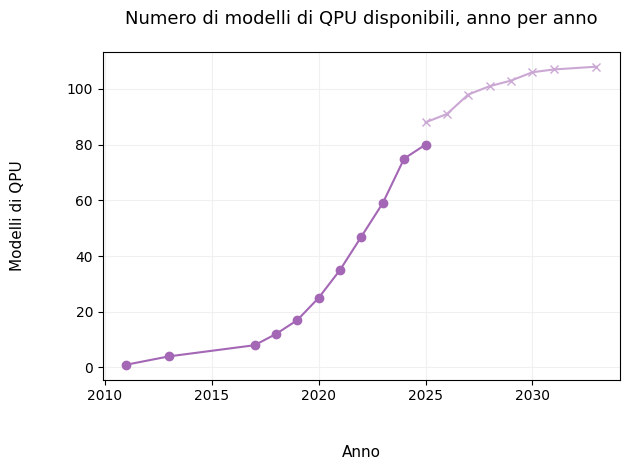

In [185]:
plan_fig = avail_plan_qpus()
plan_fig.tight_layout()
plan_fig.savefig("Media/qpus_planned.png", dpi=600)

In [ ]:
# --- Build masks -----------------------------------------------------------
mask_status  = qpu_df["Availability"].str.lower().isin(["available", "planned"])
mask_qubits  = qpu_df["Physical Qubits"].gt(0)

# --- Slice, sort and reset index ------------------------------------------
qpu_reduced_info = qpu_df.loc[mask_status & mask_qubits, ["Manufacturer", "Model", "Availability", "Availability Date", "Physical Qubits"]].sort_values("Availability Date", na_position="last").reset_index(drop=True)

In [ ]:
qpu_reduced_info["Availability Date"] = (
    qpu_reduced_info["Availability Date"]
      .dropna()                                    # ignore NaNs
      .astype(int)                                 # => 2024
      .astype(str)                                 # => "2024"
      .pipe(pd.to_datetime, format="%Y")           # => 2024-01-01 00:00:00
)

In [178]:
def qpu_scatterplot():
    availability_palette = {
        "Available": "#A467B5",
        "Planned":   "#CBA7D4"
    }
    
    fig, ax = mplPlt.subplots(figsize=(10,9))
    
    ax.set(xscale="linear", yscale="log")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis="x", labelrotation=90)
    
    ax.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.2)
    
    sns.scatterplot(
        data=qpu_reduced_info,
        ax=ax,
        x="Availability Date",
        y="Physical Qubits",
        style="Availability",
        hue="Availability",
        palette=availability_palette,
        s=50
    )

    ax.set_title('Qubit fisici, anno per anno', fontsize=24, pad=20)
    ax.set_xlabel("Anno", fontsize=18, labelpad=30)
    ax.set_ylabel("Numero di Qubits", fontsize=18, labelpad=30)

    return fig

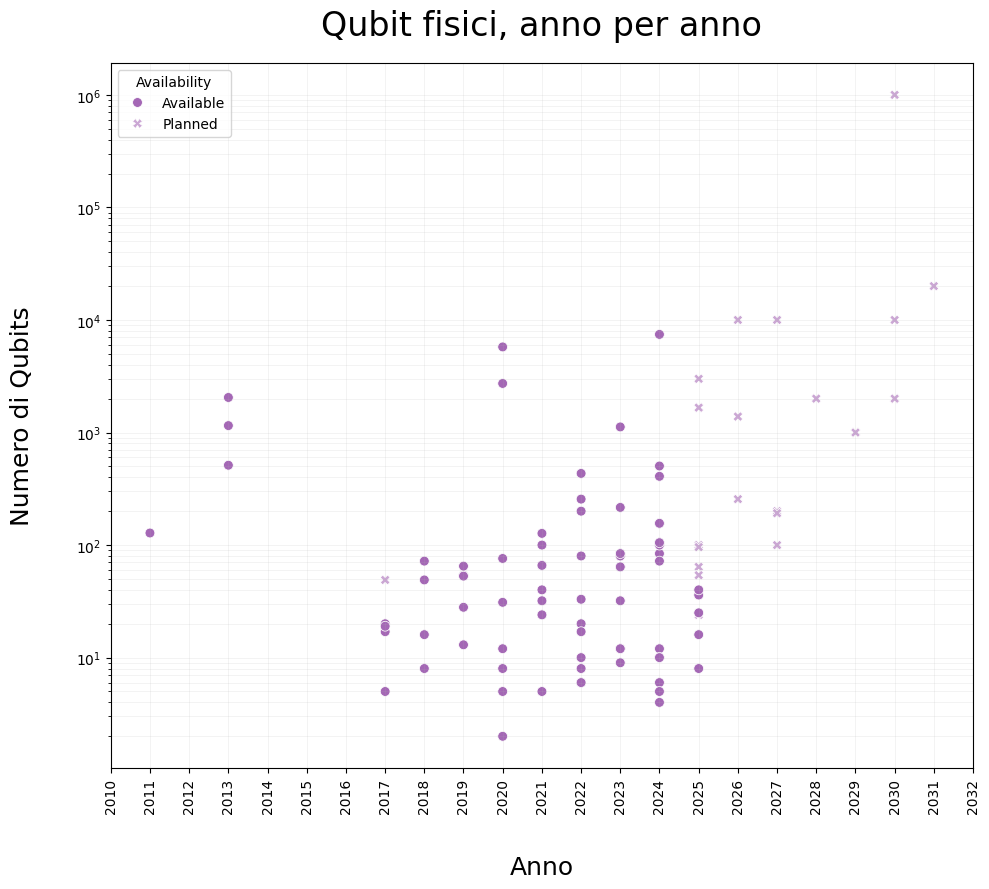

In [179]:
scpl_fig = qpu_scatterplot()
scpl_fig.tight_layout()
scpl_fig.savefig("Media/qpus_scatterplot.png", dpi=600)